In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from fastai.vision import *
from fastai import *
import os
from collections import defaultdict

### Set up paths

In [3]:
train_pd = pd.read_csv('/root/.fastai/data/severstal/train.csv')

In [4]:
train_pd.head(5)

,ImageId_ClassId,EncodedPixels
0,0002cc93b.jpg_1,29102 12 29346 24 29602 24 29858 24 30114 24 3...
1,0002cc93b.jpg_2,NaN
2,0002cc93b.jpg_3,NaN
3,0002cc93b.jpg_4,NaN
4,00031f466.jpg_1,NaN


In [5]:
path = Path('/root/.fastai/data/severstal')

In [6]:
path.ls()

[PosixPath('/root/.fastai/data/severstal/severstal-steel-defect-detection.zip'),
 PosixPath('/root/.fastai/data/severstal/test_images'),
 PosixPath('/root/.fastai/data/severstal/train_images'),
 PosixPath('/root/.fastai/data/severstal/train.csv'),
 PosixPath('/root/.fastai/data/severstal/submission.csv'),
 PosixPath('/root/.fastai/data/severstal/train_images.zip'),
 PosixPath('/root/.fastai/data/severstal/sample_submission.csv'),
 PosixPath('/root/.fastai/data/severstal/test_images.zip')]

In [7]:
train_images = get_image_files(path/'train_images')
train_images[:3]

[PosixPath('/root/.fastai/data/severstal/train_images/18ba753ff.jpg'),
 PosixPath('/root/.fastai/data/severstal/train_images/0519989b3.jpg'),
 PosixPath('/root/.fastai/data/severstal/train_images/7933cbe21.jpg')]

### Check maximum size of images

In [8]:
def check_img_max_size(folder):
    max_height = 0
    max_width = 0
    for train_image in train_images:
        img = open_image(train_image)
        if max_height < img.shape[1]:
            max_height = img.shape[1]
        if max_width < img.shape[2]:
            max_width = img.shape[2]
    return max_height, max_width

def show_image(images, index):
    img_f = images[index]
    print(type(img_f))
    img = open_image(img_f)
    print(img)
    img.show(figsize=(5,5))

In [9]:
mask_path = Path('/kaggle/mask')
if not os.path.exists(mask_path):
    os.makedirs(str(mask_path))

In [10]:
def convert_encoded_to_array(encoded_pixels):
    pos_array = []
    len_array = []
    splits = encoded_pixels.split()
    pos_array = [int(n) - 1 for i, n in enumerate(splits) if i % 2 == 0]
    len_array = [int(n) for i, n in enumerate(splits) if i % 2 == 1]
    return pos_array, len_array
        
def convert_to_pair(pos_array, rows):
    return [(p % rows, p // rows) for p in pos_array]

def create_positions(single_pos, size):
    return [i for i in range(single_pos, single_pos + size)]

def create_positions_pairs(single_pos, size, row_size):
    return convert_to_pair(create_positions(single_pos, size), row_size)

def convert_to_mask(encoded_pixels, row_size, col_size, category):
    pos_array, len_array = convert_encoded_to_array(encoded_pixels)
    mask = np.zeros([row_size, col_size])
    for(p, l) in zip(pos_array, len_array):
        for row, col in create_positions_pairs(p, l, row_size):
            mask[row][col] = category
    return mask

def save_to_image(masked, image_name):
    im = PIL.Image.fromarray(masked)
    im = im.convert("L")
    image_name = re.sub(r'(.+)\.jpg', r'\1', image_name) + ".png"
    real_path = mask_path/image_name
    im.save(real_path)
#     print(f'Image saved to ${real_path}')
    return real_path

def open_single_image(path):
    img = open_image(path)
    img.show(figsize=(20,20))
    
def get_y_fn(x):
    return mask_path/(x.stem + '.png')

def group_by(train_images, train_pd):
    tran_dict = {image.name:[] for image in train_images}
    pattern = re.compile('(.+)_(\d+)')
    for index, image_path in train_pd.iterrows():
        m = pattern.match(image_path['ImageId_ClassId'])
        file_name = m.group(1)
        category = m.group(2)
        tran_dict[file_name].append((int(category), image_path['EncodedPixels']))
    return tran_dict

def display_image_with_mask(img_name):
    full_image = path/'train_images'/img_name
    print(full_image)
    open_single_image(full_image)
    mask_image = get_y_fn(full_image)
    mask = open_mask(mask_image)
    print(full_image)
    mask.show(figsize=(20, 20), alpha=0.5)

In [11]:
grouped_categories_mask = group_by(train_images, train_pd)

### Create mask files and save these to kaggle/mask/

In [12]:
image_height = 256
image_width = 1600
for image_name, cat_list in grouped_categories_mask.items():
    masked = np.zeros([image_height, image_width])
    for cat_mask in cat_list:
        encoded_pixels = cat_mask[1]
        if pd.notna(cat_mask[1]):
            masked += convert_to_mask(encoded_pixels, image_height, image_width, cat_mask[0])
    if np.amax(masked) > 4:
        print(f'Check {image_name} for max category {np.amax(masked)}')
    save_to_image(masked, image_name)

### Prepare data bunch

In [23]:
train_images = (path/'train_images').ls()
src_size = np.array(open_image(str(train_images[0])).shape[1:])

In [62]:
codes = array(['0', '1', '2', '3', '4'])
src = (SegmentationItemList.from_folder(path/'train_images')
       .split_by_rand_pct(valid_pct=0.15)
       .label_from_func(get_y_fn, classes=codes))

In [63]:
bs = 2
size = src_size//2

In [64]:
data = (src.transform(get_transforms(flip_vert = True), size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

### Create learner and training
Starting with low resolution training

##### Some metrics functions

In [27]:
name2id = {v:k for k,v in enumerate(codes)}
void_code = name2id['0']

def acc_camvid(input, target):
    target = target.squeeze(1)
    mask = target != void_code
    argmax = (input.argmax(dim=1))
    comparison = argmax[mask]==target[mask]
    return torch.tensor(0.) if comparison.numel() == 0 else comparison.float().mean()

def acc_camvid_with_zero_check(input, target):
    target = target.squeeze(1)
    argmax = (input.argmax(dim=1))
    batch_size = input.shape[0]
    total = torch.empty([batch_size])
    for b in range(batch_size):
        if(torch.sum(argmax[b]).item() == 0.0 and torch.sum(target[b]).item() == 0.0):
            total[b] = 1
        else:
            mask = target[b] != void_code
            comparison = argmax[b][mask]==target[b][mask]
            total[b] = torch.tensor(0.) if comparison.numel() == 0 else comparison.float().mean()
    return total.mean()


def calc_dice_coefficients(argmax, target, cats):
    def calc_dice_coefficient(seg, gt, cat: int):
        mask_seg = seg == cat
        mask_gt = gt == cat
        sum_seg = torch.sum(mask_seg.float())
        sum_gt = torch.sum(mask_gt.float())
        if sum_seg + sum_gt == 0:
            return torch.tensor(1.0)
        return (torch.sum((seg[gt == cat] / cat).float()) * 2.0) / (sum_seg + sum_gt)

    total_avg = torch.empty([len(cats)])
    for i, c in enumerate(cats):
        total_avg[i] = calc_dice_coefficient(argmax, target, c)
    return total_avg.mean()


def dice_coefficient(input, target):
    target = target.squeeze(1)
    argmax = (input.argmax(dim=1))
    batch_size = input.shape[0]
    cats = [1, 2, 3, 4]
    total = torch.empty([batch_size])
    for b in range(batch_size):
        total[b] = calc_dice_coefficients(argmax[b], target[b], cats)
    return total.mean()


def accuracy_simple(input, target):
    target = target.squeeze(1)
    return (input.argmax(dim=1)==target).float().mean()


def dice_coeff(pred, target):
    smooth = 1.
    num = pred.size(0)
    m1 = pred.view(num, -1)  # Flatten
    m2 = target.view(num, -1)  # Flatten
    intersection = (m1 * m2).sum()
    return (2. * intersection + smooth) / (m1.sum() + m2.sum() + smooth)

In [28]:
metrics=accuracy_simple,acc_camvid_with_zero_check,dice_coefficient
wd=1e-2

In [29]:
learn = unet_learner(data, models.resnet34, metrics=metrics, wd=wd, bottle=True)
learn.loss_func = CrossEntropyFlat(axis=1, weight=torch.tensor([1.5, .5, .5, .5, .5]).cuda())
learn.loss_func

FlattenedLoss of CrossEntropyLoss()

In [30]:
learn.model_dir = Path('/kaggle/model')

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


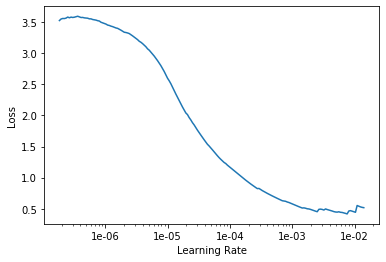

In [31]:
lr_find(learn, num_it=300)
learn.recorder.plot()

In [32]:
lr=1e-04

In [34]:
from fastai import callbacks

learn.fit_one_cycle(10, slice(lr), pct_start=0.8, 
                    callbacks=[callbacks.SaveModelCallback(learn, monitor='dice_coefficient',mode='max'),
                              callbacks.EarlyStoppingCallback(learn=learn, monitor='dice_coefficient', patience=3)])

epoch,train_loss,valid_loss,accuracy_simple,acc_camvid_with_zero_check,dice_coefficient,time
0,0.060349,0.048712,0.969704,0.237403,0.782975,08:48
1,0.096532,0.102697,0.972298,0.219220,0.785888,08:48
2,0.062245,0.044598,0.974149,0.371074,0.834122,08:48
3,0.067865,0.039450,0.971483,0.410033,0.842338,08:48
4,0.067817,0.037453,0.975208,0.472091,0.859479,08:48
5,0.051308,0.039882,0.971495,0.469779,0.860951,08:47
6,0.056166,0.036201,0.975380,0.480167,0.857628,08:48
7,0.043673,0.035696,0.975171,0.499113,0.868598,08:48
8,0.039609,0.034816,0.977488,0.550279,0.877243,08:48
9,0.067663,0.032738,0.978010,0.554256,0.873111,08:48


Better model found at epoch 0 with dice_coefficient value: 0.7829745411872864.
Better model found at epoch 1 with dice_coefficient value: 0.7858878970146179.
Better model found at epoch 2 with dice_coefficient value: 0.834122359752655.
Better model found at epoch 3 with dice_coefficient value: 0.8423384428024292.
Better model found at epoch 4 with dice_coefficient value: 0.8594788312911987.
Better model found at epoch 5 with dice_coefficient value: 0.8609514832496643.
Better model found at epoch 7 with dice_coefficient value: 0.8685978055000305.
Better model found at epoch 8 with dice_coefficient value: 0.8772428631782532.


In [35]:
learn.save('stage-1')

In [ ]:
# learn.load('bestmodel');

In [36]:
learn.export(file='/kaggle/model/export-1.pkl')

In [37]:
learn.unfreeze()

In [38]:
lrs = slice(lr/100,lr)

In [39]:
learn.fit_one_cycle(10, lrs, pct_start=0.8, 
                    callbacks=[callbacks.SaveModelCallback(learn, monitor='dice_coefficient',mode='max', name='bestmodel-unfrozen-1-mini'),
                              callbacks.EarlyStoppingCallback(learn=learn, monitor='dice_coefficient', patience=3)])

epoch,train_loss,valid_loss,accuracy_simple,acc_camvid_with_zero_check,dice_coefficient,time
0,0.025120,0.030616,0.977449,0.556089,0.876179,09:52
1,0.040584,0.031343,0.978543,0.558799,0.873326,09:52
2,0.040324,0.033223,0.977571,0.538980,0.871892,09:53
3,0.051785,0.034328,0.977047,0.551409,0.878770,09:51
4,0.044846,0.037999,0.976700,0.545671,0.880102,09:52
5,0.049214,0.036137,0.976224,0.510666,0.862560,09:53
6,0.042555,0.032805,0.974977,0.543561,0.883048,10:00
7,0.045548,0.037156,0.974205,0.539583,0.881172,09:55
8,0.038681,0.029672,0.977956,0.571670,0.887142,09:51
9,0.032589,0.046220,0.978382,0.588083,0.883972,09:53


Better model found at epoch 0 with dice_coefficient value: 0.8761793971061707.
Better model found at epoch 3 with dice_coefficient value: 0.8787696361541748.
Better model found at epoch 4 with dice_coefficient value: 0.88010174036026.
Better model found at epoch 6 with dice_coefficient value: 0.8830479383468628.
Better model found at epoch 8 with dice_coefficient value: 0.8871419429779053.


In [40]:
learn.save('stage-2');

In [ ]:
learn.load('bestmodel-unfrozen-diceloss-mini');

In [ ]:
learn.export(file='/kaggle/model/export-2.pkl')

### Go Large

In [41]:
data = (src.transform(get_transforms(flip_vert = True), size=src_size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

In [42]:
learn = unet_learner(data, models.resnet34, metrics=metrics, wd=wd, bottle=True)
learn.model_dir = Path('/kaggle/model')
learn.loss_func = CrossEntropyFlat(axis=1, weight=torch.tensor([1.5, .5, .5, .5, .5]).cuda())
learn.load('stage-2');

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


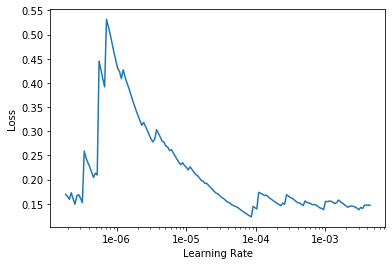

In [43]:
lr_find(learn, num_it=300)
learn.recorder.plot()

In [54]:
lr=1e-05

In [45]:
learn.fit_one_cycle(10, slice(lr), pct_start=0.3, 
                    callbacks=[callbacks.SaveModelCallback(learn, monitor='dice_coefficient',mode='max', name='bestmodel-3'),
                              callbacks.EarlyStoppingCallback(learn=learn, monitor='dice_coefficient', patience=4)])

epoch,train_loss,valid_loss,accuracy_simple,acc_camvid_with_zero_check,dice_coefficient,time
0,0.140000,0.627760,0.972818,0.409519,0.835056,27:51
1,0.149321,0.243963,0.973402,0.387769,0.827234,27:48
2,0.136935,0.125351,0.973949,0.356673,0.816066,27:49
3,0.059051,0.116486,0.974960,0.371035,0.817508,27:49
4,0.044646,0.106904,0.974231,0.338436,0.812232,27:50
5,0.056480,0.057673,0.975518,0.370960,0.816157,27:54
6,0.059160,0.049350,0.975854,0.397773,0.824563,27:52
7,0.056928,0.057527,0.975892,0.387844,0.819354,27:52
8,0.041547,0.049596,0.976038,0.387837,0.822328,27:53
9,0.047730,0.055234,0.975505,0.383378,0.824898,27:54


Better model found at epoch 0 with dice_coefficient value: 0.8350561857223511.


In [46]:
learn.save('stage-3');

In [ ]:
learn.export(file='/kaggle/model/export-3.pkl')

In [51]:
learn.load('bestmodel-3');

In [52]:
learn.load('stage-3');

In [53]:
learn.unfreeze()

In [55]:
lrs = slice(lr/1000,lr/10)

In [56]:
learn.fit_one_cycle(10, lrs, pct_start=0.8,
                   callbacks=[callbacks.SaveModelCallback(learn, monitor='dice_coefficient',mode='max', name='bestmodel-4'),
                             callbacks.EarlyStoppingCallback(learn=learn, monitor='dice_coefficient', patience=4)])

epoch,train_loss,valid_loss,accuracy_simple,acc_camvid_with_zero_check,dice_coefficient,time
0,0.074816,0.114413,0.974588,0.365914,0.816511,29:22
1,0.048352,0.037400,0.976648,0.434173,0.838839,29:21
2,0.042647,0.034617,0.977127,0.460587,0.843572,29:18


Better model found at epoch 0 with dice_coefficient value: 0.8165109157562256.
Better model found at epoch 1 with dice_coefficient value: 0.8388394713401794.
Better model found at epoch 2 with dice_coefficient value: 0.8435720801353455.


In [57]:
learn.save('stage-4');

In [ ]:
learn.load('stage-4');

In [58]:
learn.export(file='/kaggle/model/export-4.pkl')

In [ ]:
!pwd
!cp /kaggle/model/export.pkl /opt/fastai/fastai-exercises/nbs_gil
from IPython.display import FileLink
FileLink(r'export-4.pkl')

### Inference

In [ ]:
learn=None
gc.collect()

In [ ]:
test_images = (path/'test_images').ls()

In [ ]:
inference_learn = load_learner('/kaggle/model/')

In [ ]:
def predict(img_path):
    pred_class, pred_idx, outputs = inference_learn.predict(open_image(str(img_path)))
    return pred_class, pred_idx, outputs

def encode_classes(pred_class_data):
    pixels = np.concatenate([[0], torch.transpose(pred_class_data.squeeze(), 0, 1).flatten(), [0]])
    classes_dict = {1: [], 2: [], 3: [], 4: []}
    count = 0
    previous = pixels[0]
    for i, val in enumerate(pixels):
        if val != previous:
            if previous in classes_dict:
                classes_dict[previous].append((i - count, count))
            count = 0
        previous = val
        count += 1
    return classes_dict


def convert_classes_to_text(classes_dict, clazz):
    return ' '.join([f'{v[0]} {v[1]}' for v in classes_dict[clazz]])

In [ ]:
image_to_predict = train_images[16].name
display_image_with_mask(image_to_predict)
pred_class, pred_idx, outputs = predict(path/f'train_images/{image_to_predict}')
pred_class

#### Checking encoding methods

In [ ]:
encoded_all = encode_classes(pred_class.data)
print(convert_classes_to_text(encoded_all, 3))

In [ ]:
image_name = train_images[16]
print(get_y_fn(image_name))
img = open_mask(get_y_fn(image_name))
img_data = img.data
print(convert_classes_to_text(encode_classes(img_data), 3))
img_data.shape

### Loop through the test images and create submission csv

In [ ]:
import time
start_time = time.time()

defect_classes = [1, 2, 3, 4]
with open('submission.csv', 'w') as submission_file:
    submission_file.write('ImageId_ClassId,EncodedPixels\n')
    for i, test_image in enumerate(test_images):
        pred_class, pred_idx, outputs = predict(test_image)
        encoded_all = encode_classes(pred_class.data)
        for defect_class in defect_classes:
            submission_file.write(f'{test_image.name}_{defect_class},{convert_classes_to_text(encoded_all, defect_class)}\n')
        if i % 5 == 0:
            print(f'Processed {i} images\r', end='')
            
print(f"--- {time.time() - start_time} seconds ---")